In [1]:
# load libraries
import torch
import torch.nn as nn
import torch.optim as optim

import pickle
import json
import numpy as np
from collections import Counter
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score

device = torch.device("cuda:0")

In [2]:
! nvidia-smi

Sun Oct 10 00:00:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   64C    P0   150W / 250W |  13691MiB / 16280MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   

In [3]:
# load word2vec
word2vec_model = Word2Vec.load("../../data/commons/word2vec.model")

In [4]:
# load node -> neighbor list
post_id_2_neigbor_list = pickle.load(open("../../data/non-graph/neighbors_list_dict.pkl", "rb"))

In [5]:
# load node -> user mapping
post_id_2_user = pickle.load(open("../../data/non-graph/post_id_2_user_id.pkl", "rb"))

In [6]:
# load user -> posts list
user_id_2_post_ids_list = pickle.load(open("../../data/non-graph/user_id_posts_idx_list.pkl", "rb"))

In [7]:
# load text corresponding to post
post_id_2_text = pickle.load(open("../../data/non-graph/posts_id_2_text.pkl", "rb"))

In [22]:
train_labels[0]

1

In [19]:
post_id_2_text[int(train_ids[0][:-4])]

'u really think i would not have been raped by feral hindu or muslim back in india or bangladesh and a neo nazi would rape me as well just to see me cry'

In [260]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [305]:
def getcontext(x):
    l=[ou for ou in user_id_2_post_ids_list[x] if("muslim" in post_id_2_text[ou])]
    if(len(l)>20):
        l=np.random.choice(l,20)
    h=[post_id_2_text[i] for i in l]
    h=" ".join(h)
    h=h.split()
    gg=" 111111111"
    return(gg+gg.join(h))

In [306]:
def get_d(split,mode=0):
    #ids = [str(post_id_2_user[int(i[:-4])]) for i in pid[split] if 'gab' in i]
    #ids = [post_id_2_text[int(i[:-4])]+" "+str(post_id_2_user[int(i[:-4])])+" " +getcontext(post_id_2_user[int(i[:-4])]) for i in pid[split] if 'gab' in i]
    if(mode==0):
        ids = [getcontext(post_id_2_user[int(i[:-4])]) for i in pid[split] if 'gab' in i]
    else:
        ids = [post_id_2_text[int(i[:-4])] for i in pid[split] if 'gab' in i]
    
    #ids = [post_id_2_text[int(i[:-4])]+" "+str(post_id_2_user[int(i[:-4])]) for i in pid[split] if 'gab' in i]
    #ids = [getcontext(post_id_2_user[int(i[:-4])]) for i in pid[split] if 'gab' in i]
    labels = [label_dict[Counter([j["label"] for j in data[i]["annotators"]]).most_common(1)[0][0]] for i in pid[split] if 'gab' in i]
    contexts=[post_id_2_user[int(i[:-4])] for i in pid[split] if 'gab' in i]
    return np.array(ids), np.array(labels)

In [307]:
x_train, y_train = get_d("train",0)
x_val, y_val = get_d("val",0)
x_test, y_test = get_d("test",0)

In [308]:
#balanced only context
pipeline1 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline1.fit(x_train,y_train)
y_pred=pipeline1.predict(x_test)
y_pred_proba=pipeline1.predict_proba(x_test)



from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.3738    0.3704    0.3721       216
           1     0.3627    0.2426    0.2908       305
           2     0.6068    0.7282    0.6620       515

    accuracy                         0.5106      1036
   macro avg     0.4478    0.4470    0.4416      1036
weighted avg     0.4864    0.5106    0.4922      1036

roc-auc :  0.6676684055858769


In [309]:
x_train, y_train = get_d("train",1)
x_val, y_val = get_d("val",1)
x_test, y_test = get_d("test",1)

In [349]:
#balanced only pid
pipeline2 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline2.fit(x_train,y_train)
y_pred=pipeline2.predict(x_test)
y_pred_proba=pipeline2.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.4977    0.5000    0.4988       216
           1     0.5588    0.4984    0.5269       305
           2     0.7532    0.8000    0.7759       515

    accuracy                         0.6486      1036
   macro avg     0.6032    0.5995    0.6005      1036
weighted avg     0.6427    0.6486    0.6448      1036

roc-auc :  0.8020208453129712


In [350]:
for i,j,k in zip(x_test,y_test,y_pred):
    if(j!=k):
        print(i,j,k)

education or marxist indoctrination since it is well established blacks are incapable of learning anything past the age of ten unless they are half white should not blacks go to a trade school upon age <number> say learning how to pick cotton fruits and vegetables 2 1
even if you just have a loose collection of affiliated groups each group is gonna have leaders and inevitably leaders will emerge among the group of leaders who end up coordinating the groups this is just human nature debating human nature is retarded 0 2
tbtc take back the country toxic masculinity ” patriarchy harm men noxious femaleness and public slut posturing empower women neither feminism nor now could have pulled this off this is the doing of taxpayer supported state university system maga 1 0
<user> puppy no i was alone i am not a nazi white supremacist or any other type of person i am <percent> southern i support traditional values and all things with southern culture i support anything that saves confederate mo

In [311]:
y_pred_proba1=pipeline1.predict_proba(x_train)
y_pred_proba2=pipeline1.predict_proba(x_val)
y_pred_proba3=pipeline1.predict_proba(x_test)

y_pred_proba11=pipeline2.predict_proba(x_train)
y_pred_proba22=pipeline2.predict_proba(x_val)
y_pred_proba33=pipeline2.predict_proba(x_test)

In [346]:
#balanced only pid
pipeline = Pipeline([
    ('clf', SGDClassifier(loss="log",class_weight="balanced",max_iter=100)),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(np.hstack([y_pred_proba3,y_pred_proba33]),y_test)
y_pred=pipeline.predict(np.hstack([y_pred_proba3,y_pred_proba33]))
y_pred_proba=pipeline.predict_proba(np.hstack([y_pred_proba3,y_pred_proba33]))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.3906    0.8102    0.5271       216
           1     0.5752    0.2885    0.3843       305
           2     0.8322    0.7029    0.7621       515

    accuracy                         0.6033      1036
   macro avg     0.5993    0.6005    0.5578      1036
weighted avg     0.6645    0.6033    0.6019      1036

roc-auc :  0.8048539608767089


In [270]:
x_train, y_train = get_d("train",0)
x_val, y_val = get_d("val",0)
x_test, y_test = get_d("test",0)

In [271]:
#balanced only context
pipeline1 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline1.fit(x_train,y_train)
y_pred=pipeline1.predict(x_test)
y_pred_proba=pipeline1.predict_proba(x_test)



from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.3228    0.4259    0.3673       216
           1     0.3578    0.2721    0.3091       305
           2     0.6224    0.6272    0.6248       515

    accuracy                         0.4807      1036
   macro avg     0.4343    0.4417    0.4337      1036
weighted avg     0.4820    0.4807    0.4781      1036

roc-auc :  0.64735978255232


In [272]:
x_train, y_train = get_d("train",1)
x_val, y_val = get_d("val",1)
x_test, y_test = get_d("test",1)

In [273]:
#balanced only pid
pipeline2 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline2.fit(x_train,y_train)
y_pred=pipeline2.predict(x_test)
y_pred_proba=pipeline2.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.5000    0.4861    0.4930       216
           1     0.5390    0.5213    0.5300       305
           2     0.7608    0.7845    0.7725       515

    accuracy                         0.6448      1036
   macro avg     0.5999    0.5973    0.5985      1036
weighted avg     0.6411    0.6448    0.6428      1036

roc-auc :  0.8022174892584001


In [274]:
y_pred_proba1=pipeline1.predict_proba(x_train)
y_pred_proba2=pipeline1.predict_proba(x_val)
y_pred_proba3=pipeline1.predict_proba(x_test)

y_pred_proba11=pipeline2.predict_proba(x_train)
y_pred_proba22=pipeline2.predict_proba(x_val)
y_pred_proba33=pipeline2.predict_proba(x_test)

In [304]:
#balanced only pid
pipeline = Pipeline([
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(np.hstack([y_pred_proba1,y_pred_proba11]),y_train)
y_pred=pipeline.predict(np.hstack([y_pred_proba3,y_pred_proba33]))
y_pred_proba=pipeline.predict_proba(np.hstack([y_pred_proba3,y_pred_proba33]))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.4852    0.5324    0.5077       216
           1     0.5338    0.5443    0.5390       305
           2     0.7889    0.7476    0.7677       515

    accuracy                         0.6429      1036
   macro avg     0.6026    0.6081    0.6048      1036
weighted avg     0.6505    0.6429    0.6462      1036

roc-auc :  0.7978376493389128


In [238]:
#balanced only pid
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8355 1023 1045
              precision    recall  f1-score   support

           0     0.3608    0.2767    0.3132       206
           1     0.3736    0.3119    0.3400       327
           2     0.5847    0.7012    0.6377       512

    accuracy                         0.4957      1045
   macro avg     0.4397    0.4299    0.4303      1045
weighted avg     0.4745    0.4957    0.4806      1045

roc-auc :  0.6489582179198256


In [205]:
#balanced only context
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8355 1023 1045
              precision    recall  f1-score   support

           0     0.3156    0.3447    0.3295       206
           1     0.3918    0.2936    0.3357       327
           2     0.6052    0.6797    0.6403       512

    accuracy                         0.4928      1045
   macro avg     0.4375    0.4393    0.4351      1045
weighted avg     0.4813    0.4928    0.4837      1045

roc-auc :  0.6525857254898443


In [208]:
#balanced only text
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8355 1023 1045
              precision    recall  f1-score   support

           0     0.4455    0.4369    0.4412       206
           1     0.4865    0.4954    0.4909       327
           2     0.7431    0.7402    0.7417       512

    accuracy                         0.6038      1045
   macro avg     0.5584    0.5575    0.5579      1045
weighted avg     0.6042    0.6038    0.6040      1045

roc-auc :  0.7713579072412374


In [216]:
#balanced only text+uid
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8355 1023 1045
              precision    recall  f1-score   support

           0     0.4591    0.4903    0.4742       206
           1     0.4938    0.4832    0.4884       327
           2     0.7426    0.7324    0.7375       512

    accuracy                         0.6067      1045
   macro avg     0.5651    0.5686    0.5667      1045
weighted avg     0.6088    0.6067    0.6076      1045

roc-auc :  0.7714646540903117


In [233]:
#balanced only text+context+uid
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced",learning_rate="invscaling",eta0=0.001)),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8355 1023 1045
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       206
           1     0.0000    0.0000    0.0000       327
           2     0.4900    1.0000    0.6577       512

    accuracy                         0.4900      1045
   macro avg     0.1633    0.3333    0.2192      1045
weighted avg     0.2401    0.4900    0.3222      1045

roc-auc :  0.5601841849097063


/home/souvic/.conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/souvic/.conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/souvic/.conda/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [198]:
a,b=np.unique(x_test,return_counts=True)
a=[i[0] for i in zip(a,b) if(i[1]>4)]


In [199]:
t={i:[] for i in a}
for i,j in zip(x_test,y_test):
    if(i in a):
        t[i]+=[j]
ee=[]
for i in t:
    b1,b2=np.unique(t[i],return_counts=True)
    ee+=[max(b2)/min(b2)]
    

In [200]:
a,b=np.unique(x_train,return_counts=True)
a=[i[0] for i in zip(a,b) if(i[1]>4)]


In [159]:
t={i:[] for i in a}
for i,j in zip(x_train,y_train):
    if(i in a):
        t[i]+=[j]
ee=[]
for i in t:
    b1,b2=np.unique(t[i],return_counts=True)
    ee+=[max(b2)/min(b2)]
    

In [174]:
ee

[2.0,
 4.0,
 1.0,
 3.0,
 1.5,
 1.0,
 2.5,
 5.0,
 5.0,
 4.0,
 1.0,
 1.0,
 5.0,
 1.0,
 1.5,
 1.5,
 4.0,
 3.0,
 7.0,
 8.0,
 2.6666666666666665,
 5.0,
 1.0,
 5.0,
 4.0,
 2.0,
 6.0,
 7.0,
 1.5,
 1.5,
 1.5,
 3.0,
 1.5,
 1.0,
 9.0,
 3.0]

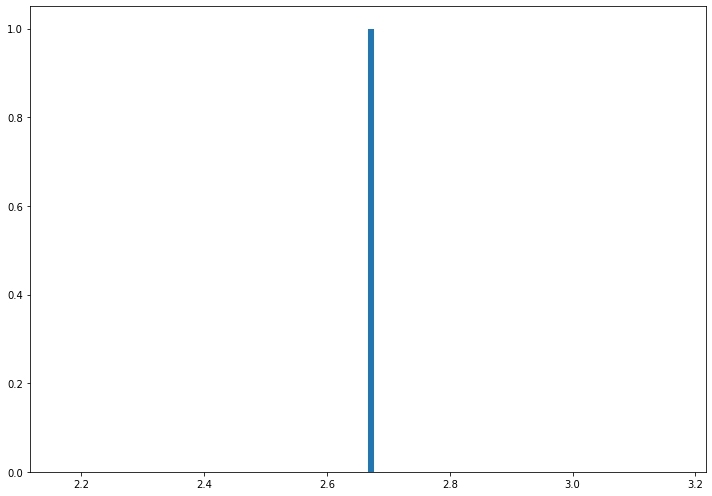

In [167]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Creating dataset
np.random.seed(23685752)
N_points = 10000
n_bins = 100

# Creating distribution
x = np.random.randn(N_points)

# Creating histogram
fig, axs = plt.subplots(1, 1,figsize =(10, 7),tight_layout = True)

axs.hist(ee, bins = n_bins)

# Show plot
plt.show()


In [148]:
np.unique(x_train,return_counts=True)

(array(['100001', '10005', '100299', ..., '99589', '9961', '99763'],
       dtype='<U6'),
 array([ 1,  6,  1, ...,  1,  6, 76]))

In [201]:
#balanced
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8355 1023 1045
              precision    recall  f1-score   support

           0     0.3314    0.2718    0.2987       206
           1     0.4320    0.2722    0.3340       327
           2     0.5507    0.7207    0.6244       512

    accuracy                         0.4919      1045
   macro avg     0.4380    0.4216    0.4190      1045
weighted avg     0.4704    0.4919    0.4693      1045

roc-auc :  0.6498737452064018


In [104]:
#balanced
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.4907    0.4907    0.4907       216
           1     0.5548    0.5148    0.5340       305
           2     0.7579    0.7903    0.7738       515

    accuracy                         0.6467      1036
   macro avg     0.6011    0.5986    0.5995      1036
weighted avg     0.6424    0.6467    0.6442      1036

roc-auc :  0.8018261057175771


In [131]:
#balanced
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced",max_iter=100)),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.5436    0.4907    0.5158       216
           1     0.4632    0.4328    0.4475       305
           2     0.7122    0.7689    0.7395       515

    accuracy                         0.6120      1036
   macro avg     0.5730    0.5642    0.5676      1036
weighted avg     0.6037    0.6120    0.6069      1036

roc-auc :  0.7647312548218288


In [97]:
#balanced
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.5050    0.4722    0.4880       216
           1     0.5411    0.5180    0.5293       305
           2     0.7546    0.7942    0.7739       515

    accuracy                         0.6458      1036
   macro avg     0.6002    0.5948    0.5971      1036
weighted avg     0.6397    0.6458    0.6423      1036

roc-auc :  0.8023287742927255


In [94]:
#balanced
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.4595    0.3935    0.4239       216
           1     0.4441    0.4689    0.4561       305
           2     0.7070    0.7262    0.7165       515

    accuracy                         0.5811      1036
   macro avg     0.5369    0.5295    0.5322      1036
weighted avg     0.5780    0.5811    0.5788      1036

roc-auc :  0.7475613944696454


In [91]:
#balanced
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log",class_weight="balanced")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.4062    0.1204    0.1857       216
           1     0.3867    0.2295    0.2881       305
           2     0.5676    0.8718    0.6876       515

    accuracy                         0.5261      1036
   macro avg     0.4535    0.4072    0.3871      1036
weighted avg     0.4807    0.5261    0.4653      1036

roc-auc :  0.6597814196503617


In [60]:
#unbalanced
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.4681    0.1019    0.1673       216
           1     0.3947    0.2951    0.3377       305
           2     0.5690    0.8408    0.6787       515

    accuracy                         0.5261      1036
   macro avg     0.4773    0.4126    0.3946      1036
weighted avg     0.4967    0.5261    0.4717      1036

roc-auc :  0.6769477840695153


In [38]:
#unbalanced
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.7125    0.2639    0.3851       216
           1     0.5776    0.4393    0.4991       305
           2     0.6464    0.9087    0.7554       515

    accuracy                         0.6361      1036
   macro avg     0.6455    0.5373    0.5466      1036
weighted avg     0.6399    0.6361    0.6028      1036

roc-auc :  0.8014879362527942


In [32]:
#unbalanced
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss="log")),
])
print(len(y_train),len(y_val),len(y_test))
pipeline.fit(x_train,y_train)
y_pred=pipeline.predict(x_test)
y_pred_proba=pipeline.predict_proba(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))
print("roc-auc : ",roc_auc_score(y_test,y_pred_proba,multi_class='ovr'))

8377 1010 1036
              precision    recall  f1-score   support

           0     0.6436    0.3009    0.4101       216
           1     0.5538    0.4721    0.5097       305
           2     0.6726    0.8816    0.7630       515

    accuracy                         0.6400      1036
   macro avg     0.6233    0.5515    0.5610      1036
weighted avg     0.6316    0.6400    0.6149      1036

roc-auc :  0.8036831815476289


In [21]:
for i in user_id_2_post_ids_list[post_id_2_user[int(train_ids[0][:-4])]]:
    if("hindu" in post_id_2_text[i]):
        print(post_id_2_text[i])

it ’ a disputed theory but many people believe jesus spent his lost years in india he gained his wisdom from studying ancient hindu and buddhist philosophy some scholars even believe he survived on the cross during crucifixion longer than average becasue he studied yoga in india and used his breathing exercises while being crucified just fascinating stuff when you read the geeta and news testament lots of similar ways of thinking
i ’ m sure if we stank less our rate for hindus would be hire
i ’ m sure if we stank less our rate for hindus would be hire
then maybe you should be more angry at the white trash libtards that are making it easier for these sullah degenerates to come here you want to blame a collective group then blame muslims not hindus we have done nothing to this country
this is what you sent me when you were muted yes i was attacked by you bottom feeding pasty corpse even though i ’ m not a fucking muslims and hindus have never attacked the west
another bottom feeding uned

In [191]:
vi=pid["train"]+pid["test"]+pid["val"]
np.random.shuffle(vi)

In [192]:
pid["train"]=vi[:len(pid["train"])]
pid["test"]=vi[len(pid["train"]):len(pid["train"])+len(pid["test"])]
pid["val"]=vi[-len(pid["val"]):]

In [178]:
def get_ids_and_labels(split):
    ids = [i for i in pid[split] if 'gab' in i]
    labels = [label_dict[Counter([j["label"] for j in data[i]["annotators"]]).most_common(1)[0][0]] for i in pid[split] if 'gab' in i]
    return np.array(ids), np.array(labels)

In [269]:
# load train/val/test split
data_path = '../../data/commons/dataset.json'
pid_path = '../../data/commons/post_id_divisions.json'

with open(pid_path) as f:
    pid = json.load(f)
with open(data_path) as f:
    data = json.load(f)

label_dict = {'normal': 0, 'offensive': 1, 'hatespeech': 2}

train_ids, train_labels = get_ids_and_labels("train")
val_ids, val_labels = get_ids_and_labels("val")
test_ids, test_labels = get_ids_and_labels("test")

In [179]:
def generate_batch(
    post_ids, post_labels, post_id_2_neigbor_list,\
    post_id_2_user, user_id_2_post_ids_list,\
    post_id_2_text, device, batch_size=32,\
    num_neighbors=2, num_user_posts=5, dim=200,\
    max_len=70, shuffle=True, mode="shuffle"
):
    if shuffle:
        shuffled_idxs = np.random.permutation(np.arange(len(post_ids)))
    else:
        shuffled_idxs = np.arange(len(post_ids))
    num_of_batches = (len(post_ids)//batch_size)+(1 if len(post_ids)%batch_size else 0)
    for i in range(num_of_batches):
        batch_idxs = shuffled_idxs[i*batch_size:(i+1)*batch_size]
        X = np.zeros((batch_size, 1 + num_neighbors + num_user_posts, max_len, dim), dtype=np.float32)
        y = post_labels[batch_idxs]
        for dim1, batch_idx in enumerate(batch_idxs):
            post_id = int(post_ids[batch_idx][:-4])
            batch_post_ids = [post_id]
            # batch_post_ids = []
            sampled_neighbors = np.random.choice(post_id_2_neigbor_list[post_id], num_neighbors)
            user_id = post_id_2_user[post_id]
            sampled_user_posts = np.random.choice(user_id_2_post_ids_list[user_id], num_user_posts)
            batch_post_ids.extend([id for id in sampled_neighbors])
            batch_post_ids.extend([id for id in sampled_user_posts])
            for dim2, post_id in enumerate(batch_post_ids):
                vecs = []
                for word in post_id_2_text[post_id].split():
                    try:
                        vecs.append(word2vec_model.wv.get_vector(word))
                    except:
                        pass
                sent_len = len(vecs)
                if sent_len >= max_len:
                    vecs = vecs[:max_len]
                else:
                    pad_len = max_len - sent_len
                    pad_vecs = []
                    for _ in range(pad_len):
                        pad_vecs.append(np.zeros((dim,)))
                    vecs = pad_vecs + vecs
                X[dim1, dim2] = np.array(vecs)
        yield torch.tensor(X[:y.shape[0]]).to(device), torch.LongTensor(y).to(device)

In [11]:
class Encoder(nn.Module):

    def __init__(self, seq_len, inp_dim):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.inp_dim = inp_dim

        self.rnn = nn.LSTM(inp_dim, inp_dim, 2, batch_first=True, bidirectional=False)
    
    def forward(self, x):
        assert x.shape[1] == self.seq_len
        assert x.shape[2] == self.inp_dim

        x, _ = self.rnn(x)
        return x

In [12]:
class Classifier(nn.Module):
    
    def __init__(self, inp_dim, out_logits):
        super(Classifier, self).__init__()

        self.inp_dim = inp_dim
        self.out_dim = out_logits

        self.fc = nn.Linear(inp_dim, out_logits)
    
    def forward(self, x):
        assert x.shape[1] == self.inp_dim

        x = self.fc(x)
        return torch.softmax(x, dim=1)

In [13]:
class Network(nn.Module):

    def __init__(self, num_seq, seq_len, inp_dim, out_logits, device):
        super(Network, self).__init__()

        self.num_seq = num_seq
        self.seq_len = seq_len
        self.inp_dim = inp_dim
        self.out_dim = out_logits
        self.device = device

        self.enc = Encoder(seq_len, inp_dim)
        # self.enc1 = Encoder(seq_len, inp_dim)
        # self.enc2 = Encoder(seq_len, inp_dim)
        self.clf = Classifier(seq_len*inp_dim*num_seq, out_logits)

    def forward(self, x):

        xs = torch.zeros(x.shape[0], self.num_seq*self.seq_len*self.inp_dim).to(self.device)
        for i in range(self.num_seq):
            xs[:,i*self.seq_len*self.inp_dim:(i+1)*self.seq_len*self.inp_dim] =\
                                        self.enc(x[:,i]).reshape(-1, self.seq_len*self.inp_dim)
        x = self.clf(xs)
        return x

In [14]:
def train(epoch_num, device, optimizer, criterion, model, batch_size=32, verbose=False):
    print("Training | Epoch:", epoch_num)
    model.train()
    if not verbose:
        for i, batch in enumerate(tqdm(generate_batch(train_ids, train_labels, post_id_2_neigbor_list,\
                                             post_id_2_user, user_id_2_post_ids_list,\
                                             post_id_2_text, device, batch_size, 0, 15),
                                    total=len(train_ids)//batch_size+(1 if len(train_ids)%batch_size else 0))):
            out = model(batch[0])
            loss = criterion(out, batch[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    else:
        for i, batch in enumerate(generate_batch(train_ids, train_labels, post_id_2_neigbor_list,\
                                                 post_id_2_user, user_id_2_post_ids_list,\
                                                 post_id_2_text, device, batch_size, 0, 15)):
            out = model(batch[0])
            loss = criterion(out, batch[1])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print("Epoch:", epoch_num, "| Iter:", i+1, "| Loss:", round(loss.item(), 4))
    model.eval()

In [15]:
def evaluate(epoch_num, device, model, batch_size=64, full=False):
    print("Evaluating | Epoch:", epoch_num)
    y_preds = []
    y_tests = []
    for batch in generate_batch(test_ids, test_labels, post_id_2_neigbor_list,\
                                 post_id_2_user, user_id_2_post_ids_list,\
                                 post_id_2_text, device, batch_size, 0, 15):
        out = model(batch[0])
        for y in batch[1].cpu().numpy():
            y_tests.append(y)
        for y in out.argmax(dim=1).cpu().numpy():
            y_preds.append(y)
    if full:
        print(classification_report(y_tests, y_preds))
    else:
        print(round(f1_score(y_tests, y_preds, average="macro"), 4), round(f1_score(y_tests, y_preds, average="micro"), 4))

In [18]:
model = Network(16, 70, 200, 3, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(20):
    train(epoch+1, device, optimizer, criterion, model, 64, verbose=False)
    evaluate(epoch+1, device, model, 64)

  0%|          | 0/131 [00:00<?, ?it/s]

Training | Epoch: 1


100%|██████████| 131/131 [01:53<00:00,  1.16it/s]


Evaluating | Epoch: 1


  0%|          | 0/131 [00:00<?, ?it/s]

0.6048 0.6506
Training | Epoch: 2


100%|██████████| 131/131 [01:52<00:00,  1.16it/s]


Evaluating | Epoch: 2


  0%|          | 0/131 [00:00<?, ?it/s]

0.6069 0.6622
Training | Epoch: 3


100%|██████████| 131/131 [01:58<00:00,  1.10it/s]


Evaluating | Epoch: 3


  0%|          | 0/131 [00:00<?, ?it/s]

0.5947 0.6554
Training | Epoch: 4


100%|██████████| 131/131 [01:27<00:00,  1.50it/s]


Evaluating | Epoch: 4


  0%|          | 0/131 [00:00<?, ?it/s]

0.6043 0.6564
Training | Epoch: 5


100%|██████████| 131/131 [01:29<00:00,  1.47it/s]


Evaluating | Epoch: 5


  0%|          | 0/131 [00:00<?, ?it/s]

0.6121 0.6622
Training | Epoch: 6


100%|██████████| 131/131 [01:26<00:00,  1.51it/s]


Evaluating | Epoch: 6


  0%|          | 0/131 [00:00<?, ?it/s]

0.6281 0.668
Training | Epoch: 7


100%|██████████| 131/131 [01:27<00:00,  1.49it/s]


Evaluating | Epoch: 7


  0%|          | 0/131 [00:00<?, ?it/s]

0.6105 0.6564
Training | Epoch: 8


100%|██████████| 131/131 [01:28<00:00,  1.47it/s]


Evaluating | Epoch: 8


  0%|          | 0/131 [00:00<?, ?it/s]

0.5866 0.6477
Training | Epoch: 9


100%|██████████| 131/131 [01:24<00:00,  1.54it/s]


Evaluating | Epoch: 9


  0%|          | 0/131 [00:00<?, ?it/s]

0.6197 0.667
Training | Epoch: 10


100%|██████████| 131/131 [01:26<00:00,  1.52it/s]


Evaluating | Epoch: 10
0.6184 0.6622


In [21]:
evaluate(1, device, model, 64, True)

Evaluating | Epoch: 1
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       216
           1       0.53      0.52      0.52       305
           2       0.76      0.82      0.79       515

    accuracy                           0.67      1036
   macro avg       0.64      0.62      0.63      1036
weighted avg       0.67      0.67      0.67      1036



In [22]:
torch.save(model.state_dict(), "1+Rand_15_63_67.pth")

In [44]:
t = model.state_dict()['clf.fc.weight'][0].cpu().numpy()
t2 = np.abs(t.reshape(16,70,-1)[:,-20:,:].reshape(16,-1)).mean(axis=1)
print(t2 / t2.sum())
t = model.state_dict()['clf.fc.weight'][1].cpu().numpy()
t2 = np.abs(t.reshape(16,70,-1)[:,-20:,:].reshape(16,-1)).mean(axis=1)
print(t2 / t2.sum())
t = model.state_dict()['clf.fc.weight'][2].cpu().numpy()
t2 = np.abs(t.reshape(16,70,-1)[:,-20:,:].reshape(16,-1)).mean(axis=1)
print(t2 / t2.sum())

[0.32450047 0.04666138 0.04523772 0.04329785 0.046474   0.04490394
 0.04590655 0.04632129 0.04313574 0.04249322 0.04831655 0.04731193
 0.04191757 0.04403957 0.04657401 0.04290824]
[0.29215732 0.04692858 0.04612512 0.0466164  0.04958789 0.04821777
 0.04744578 0.04680758 0.04759061 0.04788237 0.0482173  0.04694767
 0.04516486 0.04593274 0.04684975 0.04752821]
[0.29011226 0.0483922  0.0452545  0.04575239 0.04779587 0.04903829
 0.04844868 0.04670522 0.04592193 0.04775837 0.04891448 0.04624263
 0.04636228 0.04830711 0.04816526 0.04682856]
